In [1]:
# load all the necessary packages

from __future__ import print_function, division
from laplotter import LossAccPlotter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
# google auto augment policy
from autoaugment import ImageNetPolicy
%matplotlib inline
plt.ion()  
%load_ext autoreload
%autoreload 2


In [2]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [3]:
# set the device to use either CPU or GPU depending upon the availability

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# Constant to control how frequently we print train loss
print_every = 20
print('using device:', device)

using device: cpu


In [4]:
# ### get the images data set
# ### and divide them into training and test sets
image_dir="/Users/riteshkumar/Desktop/hyperthoridism_images/vgg_dataset/"
image_labels= "/Users/riteshkumar/Desktop/hyperthoridism_images/compiledData/final_data.csv";
training_loss={}
validation_loss= []
test_loss=[]

In [24]:
data_dir = image_dir
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.Resize((224,224)),
        transforms.ColorJitter(.3, .3, .3),
        transforms.RandomHorizontalFlip(),
        ImageNetPolicy(), 
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ColorJitter(.3, .3, .3),
        transforms.RandomHorizontalFlip(),
        ImageNetPolicy(), 
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ColorJitter(.3, .3, .3),
        transforms.RandomHorizontalFlip(),
        ImageNetPolicy(), 
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=0
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes


Loaded 136 images under train
Loaded 59 images under val
Loaded 52 images under test
Classes: 


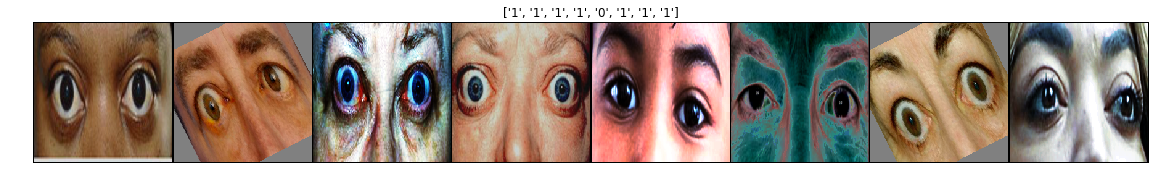

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [7]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        with torch.no_grad():
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [8]:
from laplotter import LossAccPlotter

plotter = LossAccPlotter(title="Training and Validation",
                         save_to_filepath="plot_test.png",
                         show_regressions=False,
                         show_averages=True,
                         show_loss_plot=False,
                         show_acc_plot=True,
                         show_plot_window=True,
                         x_label="Iterations")

def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    counter=1
        
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data
        with torch.no_grad():
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        print("predictions",preds)
        print("actual labels",labels)

        loss_tmp=loss.item()
        acc_tmp=torch.sum(preds == labels.data)
        acc_tmp=acc_tmp.double().item()/len(inputs)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)
        print("loss test",loss_test)
        print('acc test', acc_test.data)


        plotter.add_values(counter,loss_train=loss_tmp, acc_train=acc_tmp )

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        print(loss_test, acc_test.data, dataset_sizes[TEST])
        counter+=1

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test.double() / dataset_sizes[TEST]
    
    plotter.redraw()
    plotter.block()
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [9]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load(image_dir+"vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(

In [10]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")

In [11]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(vgg16.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/7predictions tensor([0, 1, 0, 0, 0, 0, 0, 0])
actual labels tensor([1, 0, 1, 0, 1, 1, 1, 1])
loss test 0.893965482711792
acc test tensor(1)
0.893965482711792 tensor(1) 52
predictions tensor([0, 0, 0, 0, 0, 1, 0, 0])
actual labels tensor([0, 0, 0, 1, 1, 1, 0, 0])
loss test 1.5805734395980835
acc test tensor(7)
1.5805734395980835 tensor(7) 52
predictions tensor([0, 0, 0, 0, 0, 0, 0, 0])
actual labels tensor([1, 1, 1, 1, 0, 1, 1, 1])
loss test 2.485183000564575
acc test tensor(8)
2.485183000564575 tensor(8) 52
predictions tensor([0, 0, 0, 0, 0, 0, 0, 0])
actual labels tensor([0, 1, 1, 0, 1, 0, 0, 1])
loss test 3.2381614446640015
acc test tensor(12)
3.2381614446640015 tensor(12) 52
predictions tensor([0, 0, 0, 1, 0, 0, 0, 0])
actual labels tensor([1, 1, 1, 0, 1, 0, 1, 0])
loss test 4.032020151615143
acc test tensor(14)
4.032020151615143 tensor(14) 52
predictions tensor([0, 0, 0, 0, 0, 0, 0, 0])
actual labels tensor([0, 0, 1, 1, 

<Figure size 432x288 with 0 Axes>


Evaluation completed in 0m 43s
Avg loss (test): 0.1031
Avg acc (test): 0.4231
----------


Ground truth:


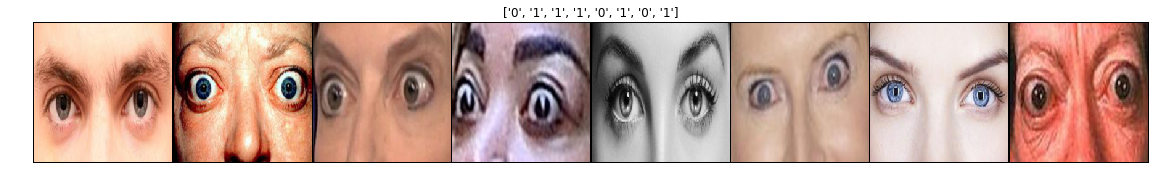

Prediction:


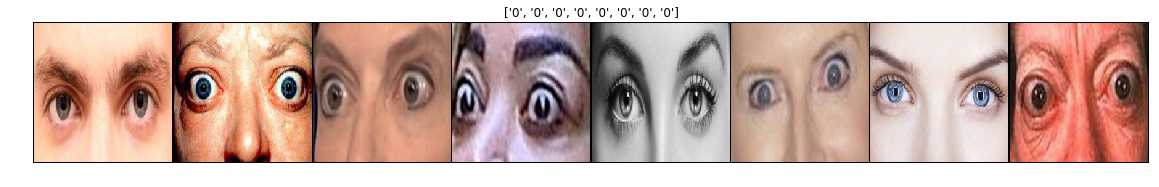

In [14]:
visualize_model(vgg16)

In [15]:
from laplotter import LossAccPlotter
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    
    # plotter
#     plotter = LossAccP lotter(save_to_filepath="plot.png")
    plotter = LossAccPlotter(title="Training and Validation",
                         save_to_filepath="plot_with_all_aug.png",
                         show_regressions=False,
                         show_averages=True,
                         show_loss_plot=True,
                         show_acc_plot=True,
                         show_plot_window=True,
                         x_label="Epochs")

    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    print("train_batches",train_batches)
    print("val_batches",val_batches)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        train_loss = 0
        train_acc = 0
        val_loss= 0
        val_acc = 0
        
        
        vgg.train(True)
        for i, data in enumerate(dataloaders[TRAIN]):
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = vgg(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            # to plot
            train_loss=loss.item()
            train_acc=torch.sum(preds == labels.data)
            train_acc=train_acc.double().item()/len(inputs)
                
            # to plot end
            print("train_loss",train_loss)
            print("train_acc",train_acc)
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train / dataset_sizes[TRAIN]
        avg_acc = acc_train.double() / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            inputs, labels = data
            with torch.no_grad():
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            val_loss=loss.item()
            val_acc=torch.sum(preds == labels.data)
            val_acc= val_acc.double().item()/len(inputs)
            
            print("val_loss",val_loss)
            print("val_acc",val_acc)
            
            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
            
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val.double() / dataset_sizes[VAL]
        plotter.add_values(epoch,loss_val=avg_loss_val, acc_val=avg_acc_val,loss_train=avg_loss, acc_train=avg_acc )
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
            
     ## plotting data
    plotter.redraw()
    plotter.block()
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

train_batches 17
val_batches 8
Epoch 0/10
----------
train_loss 0.8057297468185425
train_acc 0.375
train_loss 0.7104676961898804
train_acc 0.5
train_loss 0.6587438583374023
train_acc 0.75
train_loss 0.8097304105758667
train_acc 0.5
train_loss 0.5943868160247803
train_acc 0.625
train_loss 0.5427609086036682
train_acc 0.875
train_loss 0.46985048055648804
train_acc 0.875
train_loss 0.9927196502685547
train_acc 0.375
train_loss 0.7522615790367126
train_acc 0.5
train_loss 0.8678968548774719
train_acc 0.5
train_loss 0.689872145652771
train_acc 0.625
train_loss 0.5133796334266663
train_acc 0.75
train_loss 0.6819319128990173
train_acc 0.625
train_loss 0.6514450311660767
train_acc 0.75
train_loss 0.6492952108383179
train_acc 0.75
train_loss 0.8550287485122681
train_acc 0.5
train_loss 0.8435149788856506
train_acc 0.625

val_loss 0.4766652584075928
val_acc 0.75
val_loss 0.5818601250648499
val_acc 0.625
val_loss 0.559746265411377
val_acc 0.75
val_loss 0.37342414259910583
val_acc 1.0
val_loss 0.473

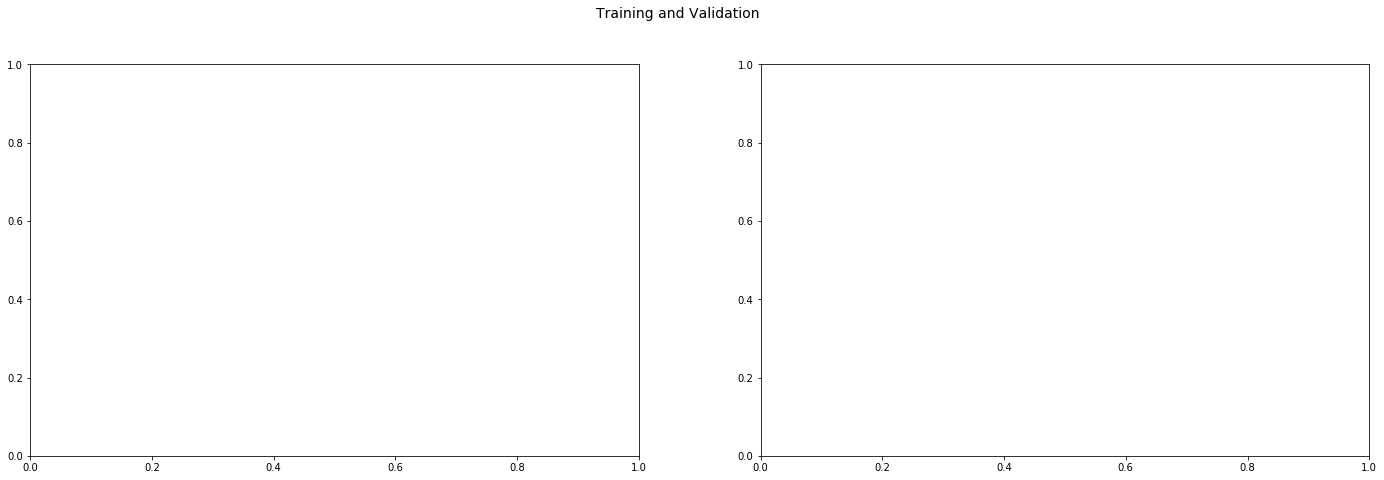


Epoch 0 result: 
Avg loss (train): 0.0889
Avg acc (train): 0.6176
Avg loss (val): 0.0689
Avg acc (val): 0.7627
----------

Epoch 1/10
----------
train_loss 0.29788678884506226
train_acc 1.0
train_loss 0.41344693303108215
train_acc 0.875
train_loss 0.30190327763557434
train_acc 1.0
train_loss 0.22621376812458038
train_acc 1.0
train_loss 0.41868796944618225
train_acc 0.75
train_loss 0.17644226551055908
train_acc 1.0
train_loss 0.7634474039077759
train_acc 0.625
train_loss 0.2717062532901764
train_acc 1.0
train_loss 0.44964802265167236
train_acc 0.875
train_loss 0.19834420084953308
train_acc 1.0
train_loss 0.17893461883068085
train_acc 1.0
train_loss 0.43728530406951904
train_acc 0.75
train_loss 0.3522035777568817
train_acc 0.625
train_loss 0.1166936382651329
train_acc 1.0
train_loss 0.3638249933719635
train_acc 0.875
train_loss 0.23583552241325378
train_acc 1.0
train_loss 0.42465195059776306
train_acc 0.875

val_loss 0.11092618852853775
val_acc 1.0
val_loss 0.4254913926124573
val_acc 0.

train_loss 0.3702644407749176
train_acc 0.75
train_loss 0.02841341495513916
train_acc 1.0
train_loss 0.02111048996448517
train_acc 1.0
train_loss 0.03462225943803787
train_acc 1.0
train_loss 0.4585224986076355
train_acc 0.75
train_loss 0.01929626613855362
train_acc 1.0

val_loss 0.06845854967832565
val_acc 1.0
val_loss 0.1371300369501114
val_acc 0.875
val_loss 0.23957553505897522
val_acc 0.875
val_loss 0.08339966833591461
val_acc 1.0
val_loss 0.04447545111179352
val_acc 1.0
val_loss 0.6427266001701355
val_acc 0.875
val_loss 0.04244885593652725
val_acc 1.0
val_loss 0.12928783893585205
val_acc 1.0

Epoch 7 result: 
Avg loss (train): 0.0127
Avg acc (train): 0.9632
Avg loss (val): 0.0235
Avg acc (val): 0.9492
----------

Epoch 8/10
----------
train_loss 0.0451098307967186
train_acc 1.0
train_loss 0.016036473214626312
train_acc 1.0
train_loss 0.2877105474472046
train_acc 0.875
train_loss 0.028971441090106964
train_acc 1.0
train_loss 0.011182591319084167
train_acc 1.0
train_loss 0.0088395476

<Figure size 432x288 with 0 Axes>


Training completed in 43m 36s
Best acc: 0.9492


In [16]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(), 'VGG16_v2_half_dataset.pt')

In [17]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/7predictions tensor([0, 0, 0, 0, 1, 1, 0, 0])
actual labels tensor([0, 0, 0, 0, 1, 1, 0, 0])
loss test 0.002084001898765564
acc test tensor(8)
0.002084001898765564 tensor(8) 52
predictions tensor([1, 0, 1, 0, 1, 1, 1, 1])
actual labels tensor([1, 0, 1, 0, 1, 1, 1, 1])
loss test 0.14997023344039917
acc test tensor(16)
0.14997023344039917 tensor(16) 52
predictions tensor([0, 0, 0, 0, 0, 1, 1, 0])
actual labels tensor([0, 0, 0, 0, 0, 1, 1, 0])
loss test 0.15165767073631287
acc test tensor(24)
0.15165767073631287 tensor(24) 52
predictions tensor([1, 0, 0, 1, 1, 1, 1, 1])
actual labels tensor([1, 0, 1, 1, 1, 1, 1, 1])
loss test 0.37384575605392456
acc test tensor(31)
0.37384575605392456 tensor(31) 52
predictions tensor([0, 1, 0, 1, 0, 1, 1, 0])
actual labels tensor([0, 1, 0, 1, 0, 1, 1, 0])
loss test 0.3768865168094635
acc test tensor(39)
0.3768865168094635 tensor(39) 52
predictions tensor([1, 0, 1, 1, 0, 0, 1, 0])
actual labels tensor([1, 0, 1, 1, 0

<Figure size 432x288 with 0 Axes>


Evaluation completed in 0m 38s
Avg loss (test): 0.0080
Avg acc (test): 0.9808
----------


Ground truth:


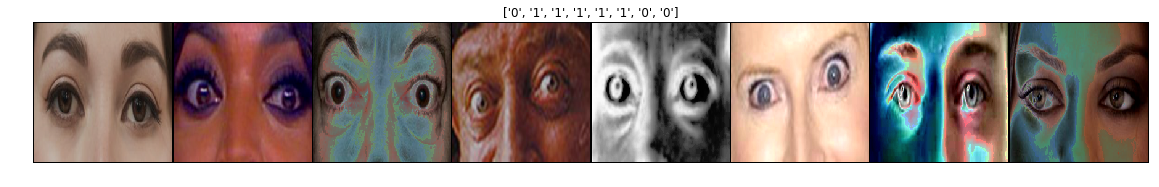

Prediction:


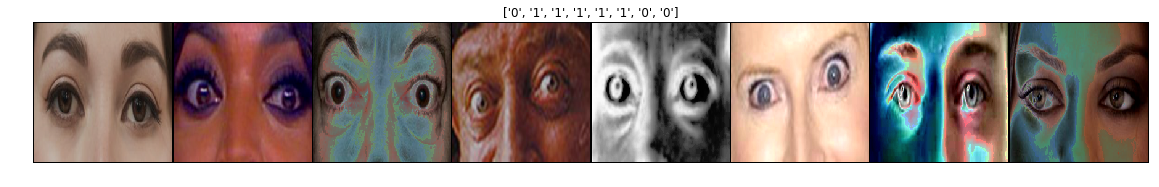

Ground truth:


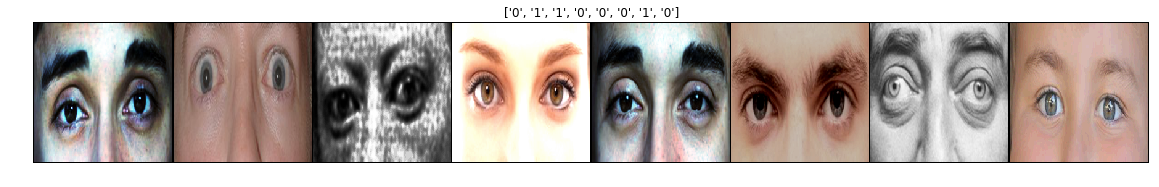

Prediction:


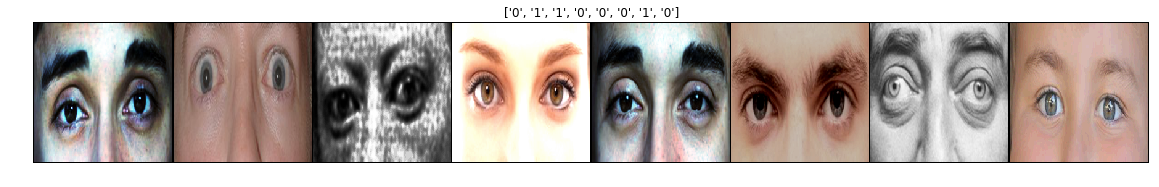

Ground truth:


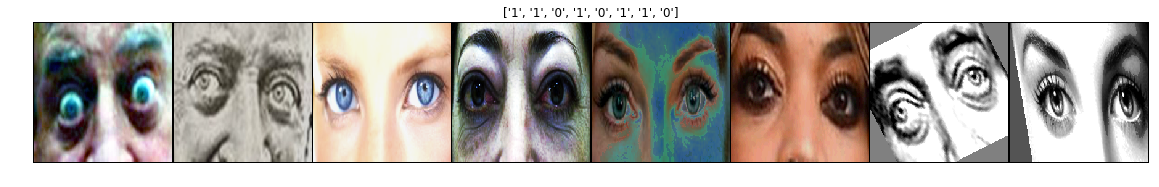

Prediction:


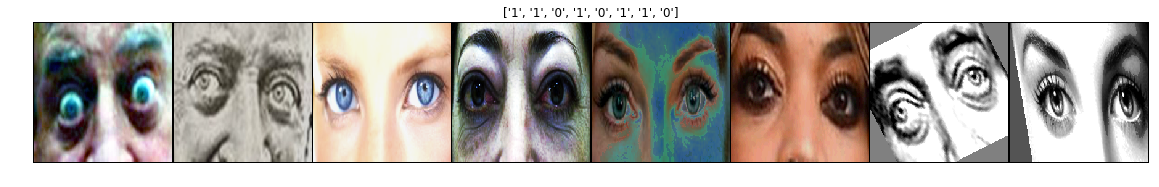

Ground truth:


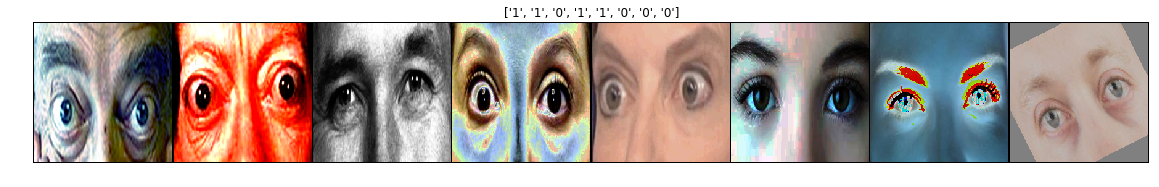

Prediction:


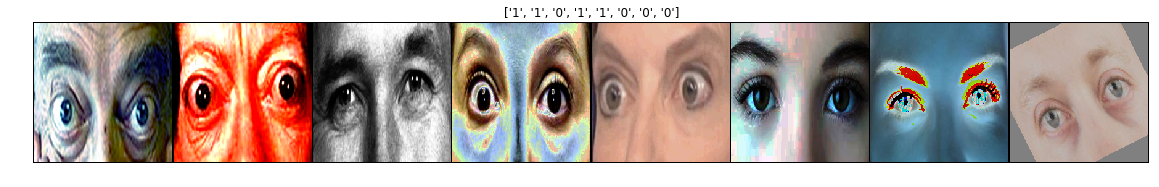

Ground truth:


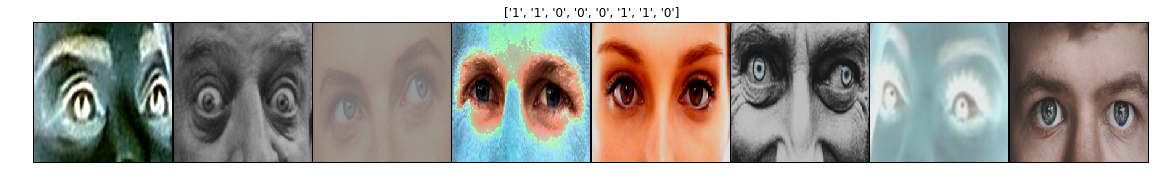

Prediction:


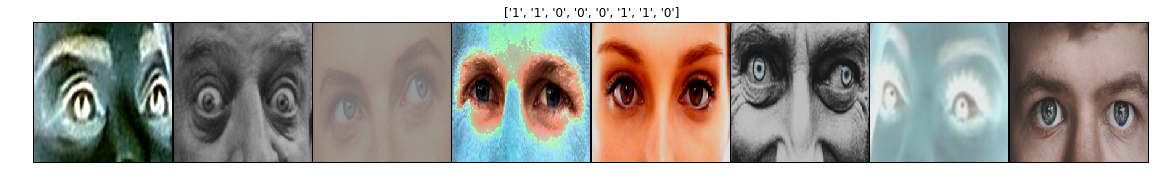

Ground truth:


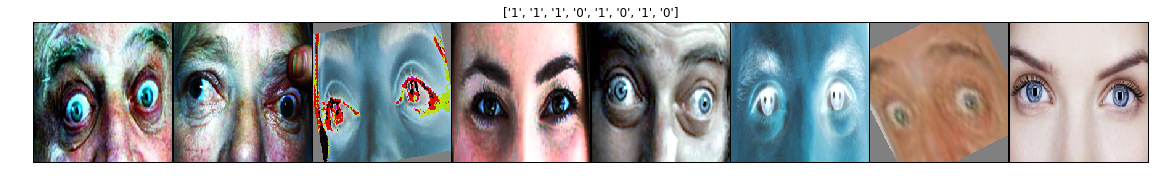

Prediction:


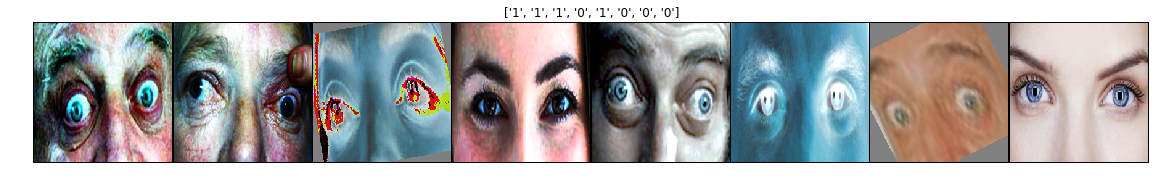

Ground truth:


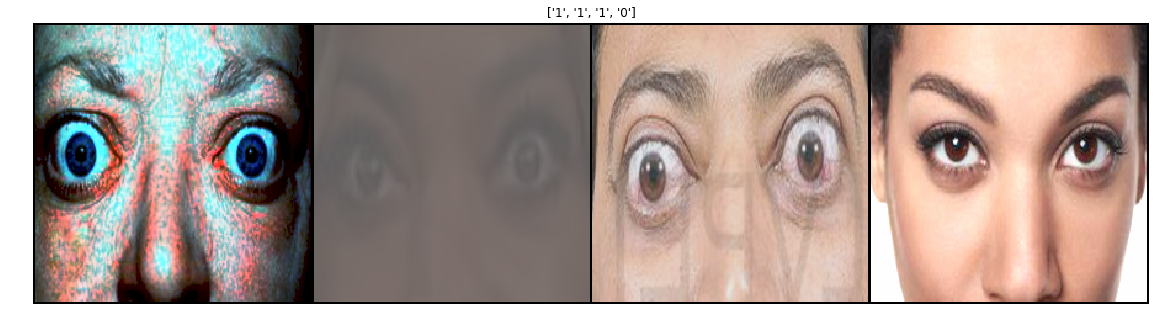

Prediction:


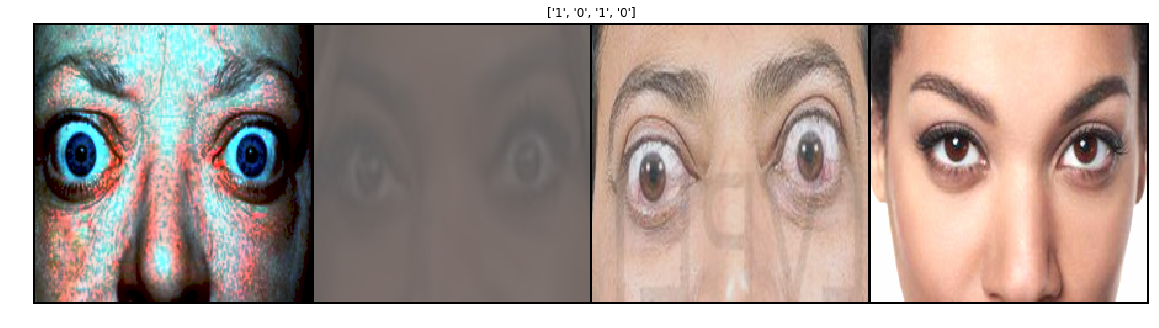

In [30]:
visualize_model(vgg16, num_images=128)